In [2]:
%pip install --upgrade pip

%pip install numpy
%pip install pandas
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.describe()


,id,name,intake_time,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,outcome_time,date_of_birth,outcome_type
count,111157,79774,111157,111157,111157,111157,111157,111155,111156,111157,111157,111157,111157,111157
unique,111157,24185,78769,48762,6,19,2,5,48,2440,569,95134,8181,5
top,A706918,Luna,09/23/2016 12:00:00 PM,Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Domestic Shorthair Mix,Black/White,04/18/2016 12:00:00 AM,05/05/2014,Adoption
freq,1,481,49,19071,82163,95010,61378,41060,16192,25361,11620,28,85,55044


In [5]:
## Data Preprocessing ##
'''
print('records with missing names:', df_train['name'].isna().sum())

print('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls
'''

"\nprint('records with missing names:', df_train['name'].isna().sum())\n\nprint('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls\n"

In [ ]:
# Rebecca's slay data exploration block /ᐠ - ˕ -マ intake time, color, outcome time, date of birth

train_sample = df_train.sample(n=5000)

# feature engineering 

# calculating DAYS in shelter
train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400
# get rid of invalid rows
train_sample = train_sample.dropna(subset=["intake_time", "outcome_time"])
train_sample = train_sample[train_sample["intake_time"] < train_sample["outcome_time"]]

# calculating the primary color of the animal in both cats and dogs 
train_sample["primary_color"] = train_sample["color"].str.split("/, ").str[0]

# age group of cats


/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/2371732943.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400
/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/2371732943.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400


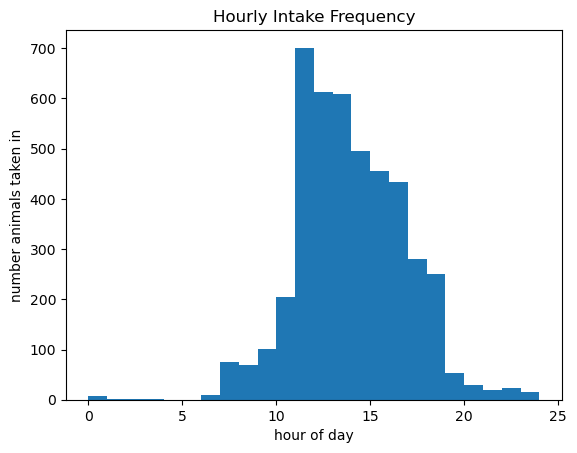

In [ ]:
# what time of day are animals brought in? 
train_sample['intake_hour'] = pd.to_datetime(df_train['intake_time'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce').dt.hour
plt.hist(train_sample["intake_hour"], bins=24, range=(0, 24))
plt.xlabel("hour of day")
plt.ylabel("number animals taken in")
plt.title("Hourly Intake Frequency") 
plt.show()

/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/2410007291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


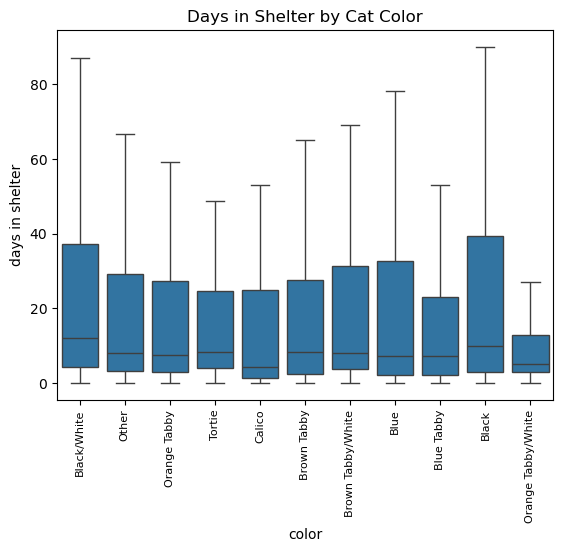

In [16]:
# CATS!
cats_sample = train_sample[train_sample["animal_type"] == "Cat"]

# narrow down to top colors for better visualization
top_colors = cats_sample["primary_color"].value_counts().nlargest(10).index
cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# get rid of invalid ones 
cats_sample = cats_sample[cats_sample["days_in_shelter"] > 0]

# plot!
sns.boxplot(data=cats_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Cat Color")
plt.show()

/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/2383781449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


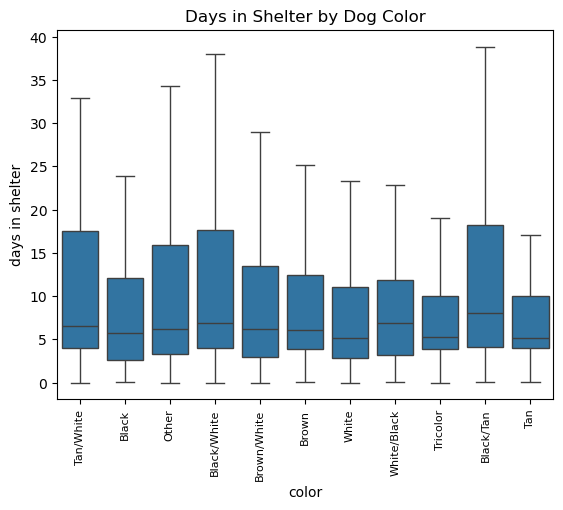

In [19]:
# dogs
dogs_sample = train_sample[train_sample["animal_type"] == "Dog"]

# only save top colors
top_colors = dogs_sample["primary_color"].value_counts().nlargest(10).index
dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# getting rid of invalid ones 
dogs_sample = dogs_sample[dogs_sample["days_in_shelter"] > 0]

sns.boxplot(data=dogs_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Dog Color")
plt.show()

/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/1273867261.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365
/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/1273867261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365
/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/1273867

([<matplotlib.patches.Wedge at 0x1799cfdd0>,
 [Text(-0.9823973985391657, 0.4948690244332127, 'Kitten'),
  Text(0.957762223524788, -0.5410097255954408, 'Adult'),
  Text(1.0987564290219405, -0.052290627104230235, 'Senior')],
 [Text(-0.5358531264759085, 0.2699285587817523, '85.1%'),
  Text(0.522415758286248, -0.2950962139611495, '13.3%'),
  Text(0.599321688557422, -0.028522160238671032, '1.5%')])

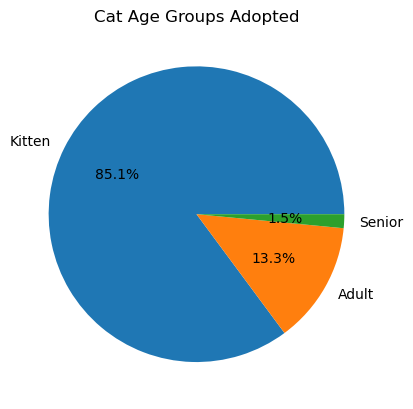

In [ ]:
# cats adoptive sample
adopted_cats = cats_sample[cats_sample["outcome_type"] == "Adoption"]

# cat age groups
adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365

def cat_age_groups(age):
    if pd.isna("age"):  
        return "Unknown"
    elif age > 10:
        return "Senior"
    elif age > 2:
        return "Adult"
    return "Kitten"

adopted_cats["age_group_when_adopted"] = adopted_cats["age_when_adopted"].apply(cat_age_groups)

adopt_age_group_counts = adopted_cats["age_group_when_adopted"].value_counts()

plt.title("Cat Age Groups Adopted")
plt.pie(adopt_age_group_counts, labels=adopt_age_group_counts.index, autopct='%1.1f%%')

/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/722849970.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365
/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_65808/722849970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365


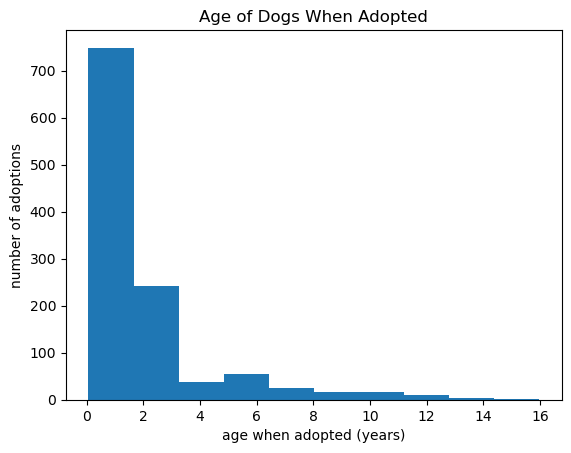

Text(0.5, 1.0, 'Age of Cats When Adopted')

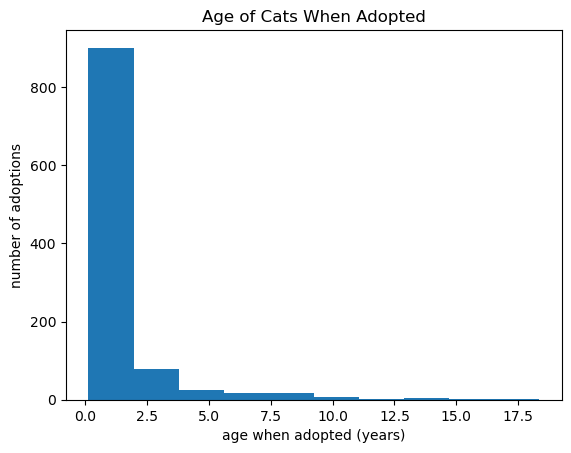

In [ ]:
# age in MONTHS that are most popular for adoption - cats and dogs 
adopted_dogs = dogs_sample.dropna(subset="outcome_type")
adopted_dogs = dogs_sample[dogs_sample["outcome_type"] == "Adoption"]
adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365

plt.hist(adopted_dogs["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Dogs When Adopted")
plt.show()

plt.hist(adopted_cats["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Cats When Adopted")

In [ ]:
# 

intake_type
Stray                 82163
Owner Surrender       21447
Public Assist          6131
Abandoned              1233
Euthanasia Request      182
Wildlife                  1
Name: count, dtype: int64
0
51648              Stray
81444    Owner Surrender
10627              Stray
78201              Stray
41279    Owner Surrender
              ...       
47527              Stray
52678              Stray
34145              Stray
80860              Stray
12342    Owner Surrender
Name: intake_type, Length: 100, dtype: object


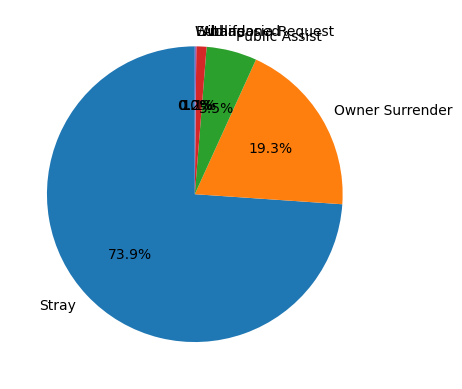

In [ ]:
# Nneoma's data visualation

# I am going to look at the Intake Type

print(df_train['intake_type'].value_counts())
plt.pie(df_train['intake_type'].value_counts(), labels=df_train['intake_type'].value_counts().index, autopct='%1.1f%%', startangle=90)

print(df_train['intake_type'].isna().sum())

In [43]:
#df_train['intake_type'].corr(df_train['intake_condition'])